# Coursework 2: Image Classification

In this coursework, we are going to develop a neural network model for for image classification.

What to do?

* The coursework includes both coding questions and written questions. Please read both the text and code comment in this notebook to get an idea what you are supposed to implement.

* First, run `jupyter-lab` or `jupyter-notebook` in the terminal to start the Jupyter notebook.

* Then, complete and run the code to get the results.

* Finally, please export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and answers, and upload the pdf file onto Cate.

Dependencies:

* If you work on a college computer in the Computer Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where required Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_2020/bin/activate`

When you no longer need the virtual environment, you can exit it by running `deactivate`.

* If you work on your own laptop using either Anaconda or plain Python, you can install new packages (such as numpy, imageio etc) running `conda install [package_name]` or `pip3 install [package_name]` in the terminal.

In [1]:
# Import libraries (provided)
import math
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

print(device)

from google.colab import drive
drive.mount('/content/drive/')



import os 
os.chdir("./drive/My Drive/Colab_Notebooks")
print(os.getcwd())


cuda:0
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab_Notebooks


# 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [0]:
# Load data (provided)
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

### 1.1 Display the dimension of the training and test sets. (5 marks)

In [3]:
train_set_len = train_set.data.size()[0]
test_set_len = test_set.data.size()[0]
print("This is the size of the training set: ", train_set.data.size()[0])
print("This is the size of the test set: ", test_set.data.size()[0])

This is the size of the training set:  60000
This is the size of the test set:  10000


### 1.2 Visualise sample images for each of the 10 classes. (10 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

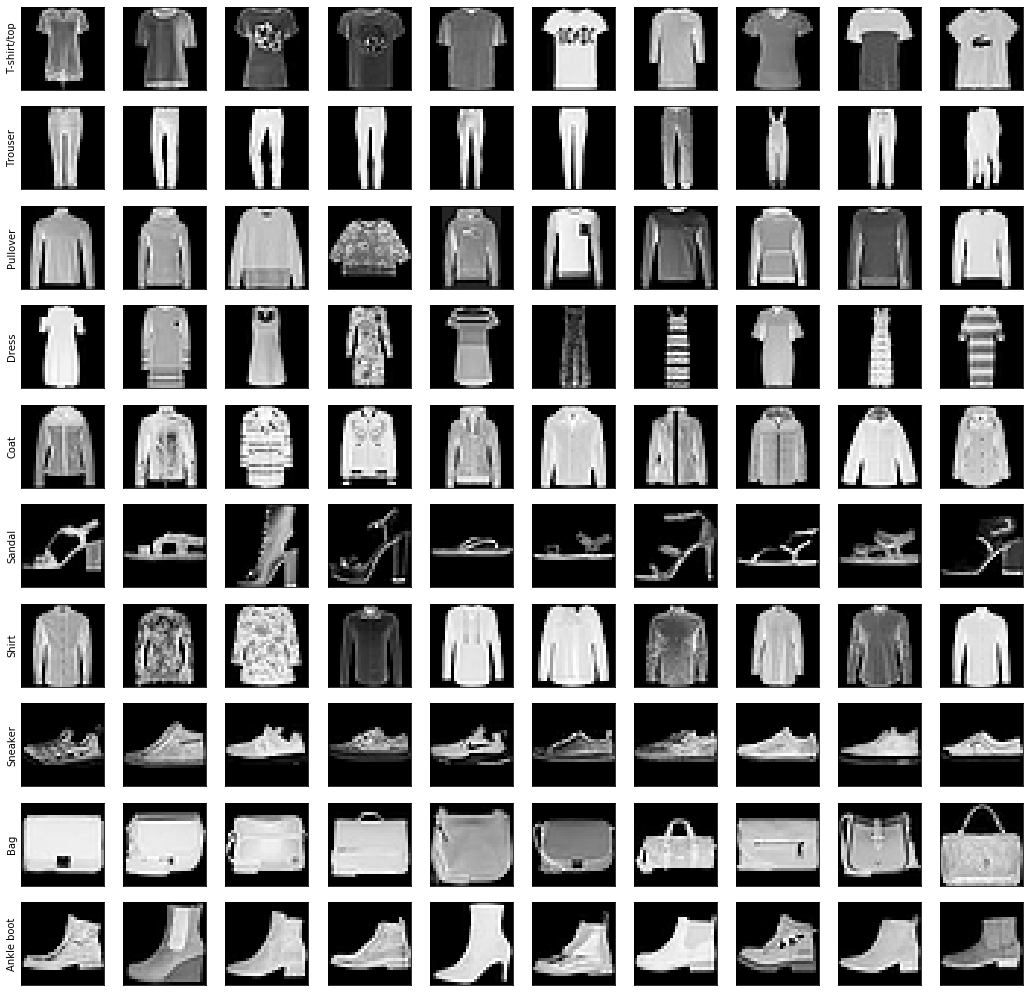

In [4]:
num_subplots = 10
fig, axs = plt.subplots(10, 10, figsize=(18,18))

for i in range(10):
    j = 0
    while j < 10:
        r = random.randint(0,train_set_len)
        if(train_label[r]==i):
            axs[i,j].imshow(train_image[r], cmap='gray')
            axs[i,j].set_yticklabels([])
            axs[i,j].set_xticklabels([])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            j+=1
    
    axs[i,0].set(ylabel=class_name[i])

### 1.3 Display the number of training samples for each class. (5 marks)

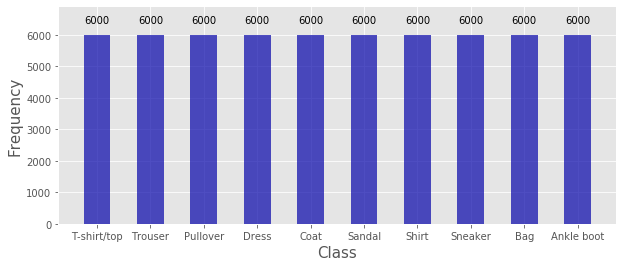

In [5]:
#get unique labels and their counts
labels, counts = np.unique(train_label, return_counts=True)

# graphical display of the number of training samples in each class
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Class", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_ylim(0,np.max(counts)+np.max(counts)*0.15)
rects = ax.bar(class_name, counts, align='center', width=0.5, color='#0504aa', alpha=0.7)

#label the bars
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%d' % int(height),ha='center', va='bottom')

plt.show()

### 1.4 Discussion. (5 marks)
Is the dataset balanced? What would happen for the image classification task if the dataset is not balanced? 

The dataset is perfectly balanced, with 6000 images in each caterogry of fashion items. If the dataset wasn't balanced, we wouldn't be able to get optimised results for the unbalanced class and it also would be a problem of making a validation sample as one particular sample would be under-represented. A few possible but simple solutions to such a problem are oversampling and undersampling.


## 2. Image classification. (60 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can use a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](lenet.png)

In [0]:
from collections import OrderedDict
class LeNet5(nn.Module):
    def __init__(self):
        
        super(LeNet5, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
            
        self.drop_out = nn.Dropout() # what is this for?
        
        self.fc1 = nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU()
        )
        
        self.fc3 = nn.Linear(84,10)

        
    def forward(self, img):
        out = self.layer1(img)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        # CrossEntropyLoss function combines 
        # SoftMax activation and cross entropy
        return out

### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [0]:
# Batch Size
batch_size = 100

# Learning Rate
learning_rate = 0.001

# Number of iterations
num_epochs = 20

# Total length of the dataset
n = len(train_image)

# Loss function
criterion = nn.CrossEntropyLoss()

# Initialize the model
model = LeNet5().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 2.3 Start model training. (20 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent. Please also evaluate how long it takes for training.

In [8]:
nr_batches = math.ceil(n / batch_size)
highes_accuracy_recorded = 0

for epoch in range(num_epochs):
    indices = np.random.permutation(n)
    img_shuffled = train_image[indices].astype(np.float32)
    lab_shuffled = train_label[indices]
           
    img_batches = np.array_split(img_shuffled, nr_batches)
    lab_batches = np.array_split(lab_shuffled, nr_batches)
 
    for i, (img_batch, lab_batch) in enumerate(zip(img_batches, lab_batches)):
      
        images = torch.from_numpy(img_batch)[:, None, :, :].to(device)
        labels = torch.from_numpy(lab_batch).to(device)
        
        #run forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backprop and perform Adam optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, loss.item(),
                  (correct / total) * 100))
    
    #save the model for the first 10 epochs
    if epoch < 10:
      highes_accuracy_recorded = correct/total
      torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')
      print('Saving model with accuracy of: {:.2f}%'.format(highes_accuracy_recorded*100))
    
    # after 10 epochs only save the model with an improved accuracy
    elif highes_accuracy_recorded < correct/total:
      highes_accuracy_recorded = correct/total
      print('Saving model with the new highest accuracy of: {:.2f}%'.format(highes_accuracy_recorded*100))
      torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')
    
    #do nothing 
    else:
      pass

    

Epoch [1/20], Loss: 0.4440, Accuracy: 88.00%
Saving model with accuracy of: 88.00%
Epoch [2/20], Loss: 0.3723, Accuracy: 88.00%
Saving model with accuracy of: 88.00%
Epoch [3/20], Loss: 0.3222, Accuracy: 90.00%
Saving model with accuracy of: 90.00%
Epoch [4/20], Loss: 0.4969, Accuracy: 82.00%
Saving model with accuracy of: 82.00%
Epoch [5/20], Loss: 0.3639, Accuracy: 90.00%
Saving model with accuracy of: 90.00%
Epoch [6/20], Loss: 0.3646, Accuracy: 83.00%
Saving model with accuracy of: 83.00%
Epoch [7/20], Loss: 0.2410, Accuracy: 91.00%
Saving model with accuracy of: 91.00%
Epoch [8/20], Loss: 0.4746, Accuracy: 83.00%
Saving model with accuracy of: 83.00%
Epoch [9/20], Loss: 0.2995, Accuracy: 88.00%
Saving model with accuracy of: 88.00%
Epoch [10/20], Loss: 0.2880, Accuracy: 87.00%
Saving model with accuracy of: 87.00%
Epoch [11/20], Loss: 0.2585, Accuracy: 90.00%
Saving model with the new highest accuracy of: 90.00%
Epoch [12/20], Loss: 0.1681, Accuracy: 93.00%
Saving model with the n

### 2.4 Deploy the trained model onto the test set. (10 marks)
Please also evaluate how long it takes for testing.

In [0]:
trained_model = LeNet5().to(device)
checkpoint = torch.load('checkpoint.pth.tar')
trained_model.load_state_dict(checkpoint['state_dict'])

trained_model.eval()
n = test_image.shape[0]
nr_batches = math.ceil(n / batch_size)

with torch.no_grad():
    correct=0
    total=0
    
    img = test_image.astype(np.float32)
    lab = test_label

    img_batches = np.array_split(img, 1)
    lab_batches = np.array_split(lab, 1)

    
    for img_batch, lab_batch in zip(img_batches, lab_batches):
        images = torch.from_numpy(np.array(img_batch))[:, None, :, :].to(device)
        labels = torch.from_numpy(lab_batch).to(device)
        
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [10]:
print('Test Accuracy of the model on the 10000 test images: %.2f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 89.47 %


### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

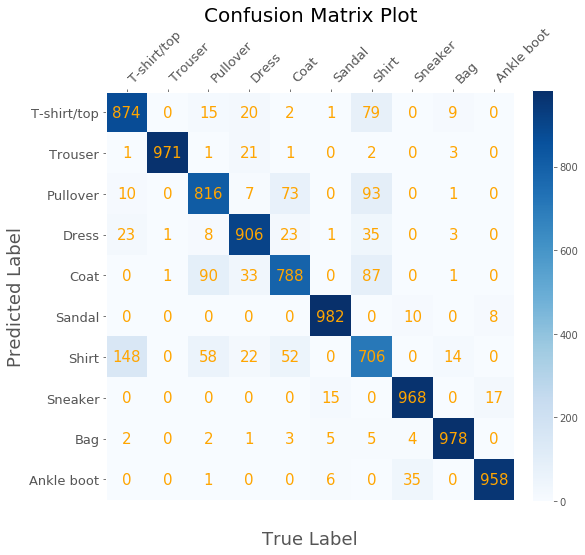

In [11]:
cm = metrics.confusion_matrix(labels.cpu(), predicted.cpu())

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap=plt.cm.Blues)
fig.colorbar(cax, fraction=0.046, pad=0.04) 
ax.grid(False)

#annotate with exact numbers in boxes
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.annotate(cm[i,j],xy=(j,i),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=15,color='orange')

plt.title("Confusion Matrix Plot", pad = 50, fontdict={'fontsize': 20})

ax.xaxis.tick_top()

ax.tick_params(axis='both', labelsize=13)
ax.set_yticks(range(len(class_name)),minor=False)
ax.set_xticks(range(len(class_name)), minor=False)
ax.set_xticklabels(class_name, minor=False, rotation=45, ha='left')
ax.set_yticklabels(class_name, minor=False)

plt.xlabel('True Label', fontsize=18, labelpad=30)
plt.ylabel('Predicted Label', fontsize=18)
ax.set_ylim(10-0.5, -0.5)

plt.rcParams["axes.edgecolor"] = "0.6"
plt.rcParams["axes.grid"] = False
plt.show()

## 3. Deploy in real world. (15 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use either Python or other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28.

### 3.1 Load and visualise your own images (5 marks)

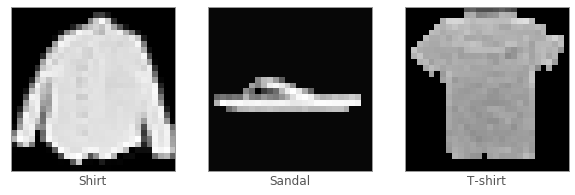

In [12]:
import matplotlib.image as mpimg

item1 = mpimg.imread('personal_items/6/shirt.png')
item2 = mpimg.imread('personal_items/5/flip-flop.png')
item3 = mpimg.imread('personal_items/0/t-shirt.png')
item_array = [item1, item2, item3]

pers_lab_names = ["Shirt", "Sandal", "T-shirt"]

fig, axs = plt.subplots(1, 3, figsize=(10,30))


for i in range(3):
    axs[i].imshow(item_array[i], cmap='gray')
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

    axs[i].set(xlabel=pers_lab_names[i])


### 3.2 Test your network on the real images and display the classification results. (5 marks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


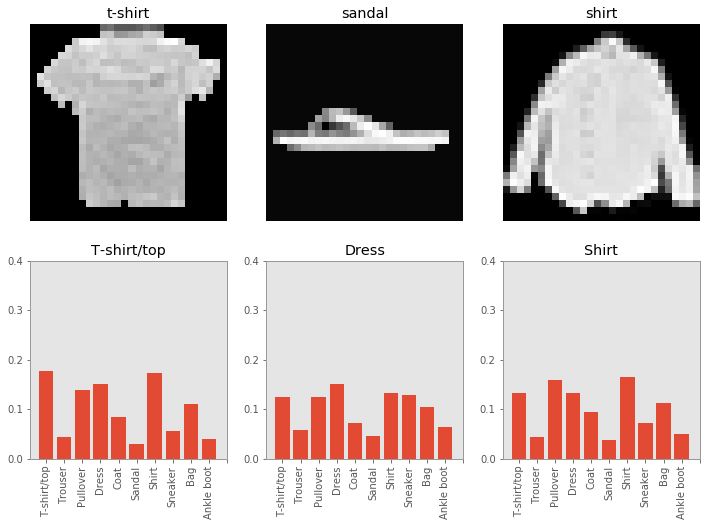

In [13]:
trans = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
personal_test_set = torchvision.datasets.ImageFolder(root='personal_items', transform=trans)

# torch generates new labels (0,1,2 for the items)
# lines below show a dict of these labels in relation to the original labels (0-10)
conversion = {0:0, 1:5, 2:6}
class_names = {0:"t-shirt", 1:"sandal", 2:"shirt"}

#load the data
test_loader = torch.utils.data.DataLoader(dataset=personal_test_set, batch_size=1, shuffle=False)

f,axarr = plt.subplots(2,3,figsize=(12,8))
for i, item in enumerate(test_loader):
    axarr[0,i].set_title(class_names[item[1].item()])
    axarr[0,i].imshow(item[0][0][0], cmap='gray')
    axarr[0,i].axis('off')
    
trained_model.eval()
with torch.no_grad():
    correct = 0
    total = 3
    i = 0
    for images, torch_assigned_labels in test_loader:
        labels = torch.tensor(conversion[torch_assigned_labels.item()]).unsqueeze(0)
        outputs = trained_model(images.to(device)).cpu()
        _, predicted = torch.max(outputs.data, 1)
        
        axarr[1,i].bar(np.arange(10),F.softmax(outputs.data).numpy()[0])
        axarr[1,i].set_title(class_name[predicted])
        axarr[1,i].set_xticklabels(class_name, rotation=90)
        axarr[1,i].set_xticks(np.arange(0,10.5,1))
        axarr[1,i].set_yticks(np.arange(0,0.42,0.1))
      
        correct += (predicted == labels).sum().item()
        i+=1
        
plt.show()

### 3.3 Discuss the classification results. (5 marks)

Does the model work? Is there anyway to improve the real life performance of the model?

The model works, and it managed to correctly classify the shirt and the t-shirt out of the three items I have chosen for it to classify (t-shirt, sandal and a shirt). However the performance for the sandal is extremely poor, where it classifies it as a dress. The model's performance is not great on my images, but this might have been caused due to no transformations being applied to the training set. Not having transformed the data at the beggining before training the model, might mean that the the model was only able to identfy items in certain orientations. To improve the performance an adaptive learning rate could be introduced, so that it ensures there is no overshooting during the gradient descent operation when the model is being trained. Secondly a series of transformations could have been applied to the images before training the model.